# Russian Layout Optimization with Bigrams

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
from math import floor
from collections import defaultdict

import colorsys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
    - [Visualizing bigrams in QGIS](#qgis)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

# Initialization and Code <a name="init">

In [2]:
# leter categories. V = vowel, C = consonant.
# nb: So-called "soft sign" Ь and "hard sign" Ъ are ancient vowels, and labelled as such.
LT = {'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'}

# these keys MUST be in any layout, otherwise the code throws an exception and halts
BASE_KEYS = set('ё-!?%*():;йцукенгшщзхъфывапролджэячсмитьбю.,⌴¶')


class Corpus:
    def __init__(self, bigrams):
        self.bigrams = bigrams
        
    def from_string(raw_text):
        # we take text and encode it, replacing space, linebreak and tab with displayable surrogates.
        # (layouts are encoded with spaces and linebreaks as separators, so this way we won't confuse them)
        text = raw_text.lower().replace(' ', '⌴').replace('\n', '¶').replace('\t', '→')

        nums = defaultdict(int)
        for i in range(2, len(text)):
            nums[text[i-2:i]] += 1

        bigrams = pd.DataFrame(nums.items(), columns=['bigram', 'num'])
        bigrams['l1'] = bigrams.bigram.str[:1]
        bigrams['l2'] = bigrams.bigram.str[1:]
        for i in (1, 2):
            bigrams[f't{i}'] = bigrams[f'l{i}'].map(lambda l: 'v' if l.lower() in LT['v'] else ('c' if l.lower() in LT['c'] else '-'))       
        bigrams['freq'] = bigrams.num / bigrams.num.sum()
        return Corpus(bigrams)
        
    # simple function that reads the corpus and creates a bigram table.
    def from_path(path):
        """Reads file from path and calculates bigrams frequencies."""
        with open(path) as f:
            return Corpus.from_string(f.read())
    
    def display_outerness(self, filter_expr, left_hand=False):
        """Provide a `filter_expr` to filter the bigrams of the corpus,
        and this function will display a table and a plot with
        where a letter is more often in digrams in the subset.

        E.g. English S more often comes first among consonants.
        So it will be on the right (towards right hand pinky)."""
        d2 = self.bigrams[self.bigrams.eval(filter_expr)]
        t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer', lsuffix='_out', rsuffix='_in')
        t2.fillna(0, inplace=True)
        t2['outer'] = - t2.freq_in + t2.freq_out
        t2['frequency'] = t2.freq_in + t2.freq_out
        t2['outerness'] = t2.outer / t2.frequency
        t2 *= 10000
        title = 'left hand: pinky <-> index' if left_hand else 'right hand: index <-> pinky'
        ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
        for i, r in t2.iterrows():
            ax.annotate(i, (r.outerness + .1, r.frequency + .1))

        return t2.sort_values('outerness') # to readable numbers

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [3]:
CORP = Corpus.from_path('sampletexts.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [4]:
CORP.bigrams

,bigram,num,l1,l2,t1,t2,freq
0,⌴п,9508,⌴,п,-,c,0.015174
1,по,5872,п,о,c,v,0.009371
2,ос,3253,о,с,v,c,0.005192
3,св,709,с,в,c,c,0.001132
4,вя,168,в,я,c,v,0.000268
...,...,...,...,...,...,...,...
1411,эв,2,э,в,v,c,0.000003
1412,н;,1,н,;,c,-,0.000002
1413,пб,1,п,б,c,c,0.000002
1414,д»,1,д,»,c,-,0.000002


In [5]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


,num
l2,
о,47644
а,39920
е,38322
и,28066
л,24611
н,23684
т,23017
р,20650
с,16738


,freq_out,freq_in,outer,frequency,outerness
э,0.000000,0.734130,-0.734130,0.734130,-10000.000000
ё,0.000000,0.063837,-0.063837,0.063837,-10000.000000
ю,0.526658,28.184209,-27.657551,28.710868,-9633.129516
я,3.016317,42.707216,-39.690899,45.723533,-8680.628272
е,17.108421,75.503677,-58.395256,92.612098,-6305.359297
и,35.876615,13.661202,22.215413,49.537817,4484.536082
о,30.562152,8.586129,21.976023,39.148281,5613.534448
у,13.357975,3.495097,9.862877,16.853072,5852.272727
а,46.266151,3.096114,43.170037,49.362264,8745.554478
ъ,1.899162,0.000000,1.899162,1.899162,10000.000000


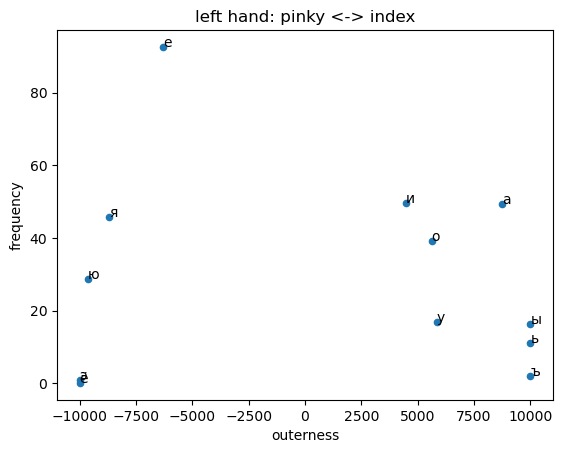

In [6]:
CORP.display_outerness("t1 == 'v' & t2 == 'v'", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

,freq_out,freq_in,outer,frequency,outerness
ц,1.739569,9.830959,-8.091390,11.570528,-6993.103448
щ,0.718171,3.191870,-2.473699,3.910040,-6326.530612
н,63.502247,164.333410,-100.831163,227.835657,-4425.609414
р,66.438767,149.922118,-83.483351,216.360886,-3858.523272
л,44.015883,94.112277,-50.096394,138.128160,-3626.805315
к,53.942597,96.905163,-42.962566,150.847761,-2848.074482
т,88.015806,148.437899,-60.422093,236.453705,-2555.345572
м,19.933226,20.188576,-0.255350,40.121802,-63.643596
в,68.593279,60.677442,7.915837,129.270722,612.345679
д,54.181988,37.584265,16.597722,91.766253,1808.695652


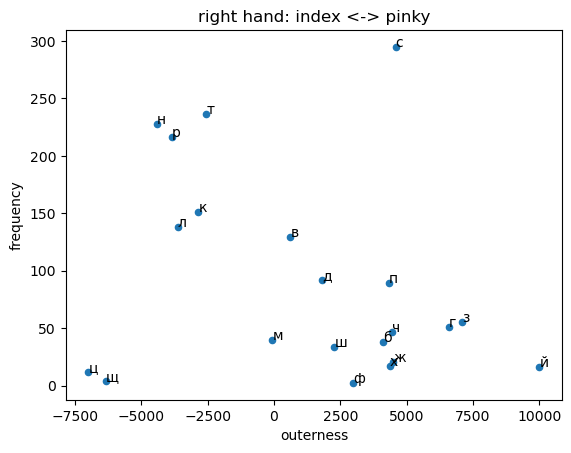

In [7]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [8]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# The Code with The Scoring Rules <a name="scoring-code">

Here we define what fingers press what keys. 0 = left pinky, 9 = right pinky, others in between as you may imagine, left to right.

Spaces & line breaks in beginning of FINGERS/POS_PENALTY are insignificant, but spaces in actual lines with numbers are. These positions must be matched by keyboard descriptions. 

In [9]:
d = {'a': {'id': 1, 'val': 2}, 'b': {'id': 3, 'val': 4}}
pd.DataFrame.from_dict(d, orient='index')

,id,val
a,1,2
b,3,4


In [10]:
STANDARD_FINGERS = '''
001233 6678999
001233 66789999
 01233 6678999
 01233 66789
4
''' 

STANDARD_PENALTIES = '''
321123 3211123
210012 21001234
 00001 1000012
 00002 20001
0
'''

# min(standard, 1) for non-home row
# STANDARD_PENALTIES = """
# 321123 3211123
# 211112 21001123
#  00001 1000012
#  11112 21111
# 0
# """

# standard + 1 everywhere in non-home pos
# STANDARD_PENALTIES = """
# 432234 4322234
# 322223 32112234
#  00002 2000023
#  11113 31112
# 0
# """

In [11]:
def parse_layer(text):
    "Parses text of a layer of layout, fingers or position penalties."
    keys_map = {}
    for ir, row in enumerate(text.lstrip().rstrip().split('\n')):
        for ic, f in enumerate(row):
            if f != ' ' and f != '∅':
                keys_map[(ir, ic)] = f
    return keys_map


def get_finger_props(finger):
    return {
        'finger': finger,  # finger unique ID. (left pinky = 0, left ring = 1, ... right pinky = 9)
        'ftype': floor(abs(4.5 - finger)),  # number in its hand (thumb = 0, pinky = 4)
        'hand': (0 if finger < 4.5 else 1), # hand numebre. Left = 0, right = 1
        'penalty': 0, # position penalty (ie. monogram). From POS_PENALTY
    }

    
KEYCAP_LAYER_SHIFTS = {
    0: (0, 0),
    1: (-.2, .2),
    2: (.2, -.2),
    3: (.5, .6),
    -1: (0, 0)
}


def lighten_color(color, amount=0.5):
    c = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(color))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def color_scale(val, min_val, max_val, scale=plt.cm.plasma, lighten=.5):
    return lighten_color(scale((val - min_val) / (max_val - min_val)), lighten)


class Keyboard:
    """Keeps fingers and penalties map of a model or a fingers positioning scheme."""
    def __init__(self, name, fingers, penalties, key_shape=None, extra_keys=None):
        """Creates the instance. Fingers and penalties are strings with lines as rows,
        and line positions of chars as columns. They must match exactly.
        
        Parameters
        ----------
        - name, str: just the name
        - fingers, str: string, where line is row, char pos is column, and the number in there (0..9)
            is the finger. 0 = left pinky, 1 = left ring, .. 9 = right pinky.
            Penalties map and layouts must reproduce these positions.
        - penalties, str: integer penalties in the same positions.
        - key_display, function: a callback that processes a key to be rendered.
            Like adding stagger, depending on row/column.
            Input params: (x: float, y: float, width: float, height: float, keycap: list[str])
            Output: a tuple with the same items.
            This callback won't process `extra_keys`.
        - extra_keys, list: a list of tuples of extra keys to render in the image:
            (x: float, y: float, width: float, height: float, keycap: str).
            Keycap is a single string.

        """
        self.name = name
        self.extra_keys = extra_keys or []
        self.key_shape = key_shape
        self.keymap = {}
        for (ir, ic), f in parse_layer(fingers).items():
            props = get_finger_props(int(f))
            self.keymap[(ir, ic)] = props

        for (ir, ic), p in parse_layer(penalties).items():
            if (ir, ic) not in self.keymap:
                raise ValueError("Penalties map doesn't match fingers map!")
            
            self.keymap[(ir, ic)]['penalty'] = int(p)
    
    def key_coords(self):
        all_keys = []
        for (ir, ic), k in self.keymap.items():
            if self.key_shape:
                x, y, w, h = self.key_shape(ic, ir, 1, 1)
            else:
                x, y, w, h = ic, ir, 1, 1
            
            all_keys.append((ir, ic, x, y, w, h, None))
        
        width = max(i[2] + i[4] for i in all_keys) - min(i[2] for i in all_keys)         
        height = max(i[3] + i[5] for i in all_keys) - min(i[3] for i in all_keys) 
        return all_keys, width, height
        
        
    def raw_display(self, key_caps=None, colors=None, title=None):
        all_keys, width, height = self.key_coords()
        for (x, y, w, h, cap) in self.extra_keys:
            all_keys.append((None, None, x, y, w, h, cap))
        
        fig, ax = plt.subplots(1, 1, figsize=(width, height))
        ax.set_axis_off()
        ax.set_title(title)
        
        font = {'family': 'dejavu sans',
            'color':  '#000',
            'size': 14,
            'linespacing': 1.7,
            'ha': 'center'
        }
        
        max_x = max_y = min_x = min_y = 0
        
        for ir, ic, x, y, w, h, cap in all_keys:
            if cap:
                caps = [cap]
            elif key_caps:
                caps = key_caps.get((ir, ic), [])
            else:
                caps = []
            key_color = colors.get((ir, ic), '#ccc')
                
            y *= -1
            min_x = min(x, min_x)
            min_y = min(y, min_y)
            max_x = max(x + w, max_x)
            max_y = max(y + h, max_y)        

            # we draw the rectangle making a outer margin of 0.2.
            # We just shift the box right-bottom, and make it narrower and lower by 0.4,
            # so that all keys are still referred by key size (1 unit = 20mm),
            # and this is done consistently everywhere.
            ax.add_patch(Rectangle((x + .2, y + .2 - h + 1), w - .4, h - .4,
               color=key_color, ec=key_color, 
               capstyle='round', linewidth=15, linestyle='-', joinstyle='round'))
            
            if key_caps is None:
                continue
            
            if not isinstance(caps, (list, tuple)):
                caps = (caps,)
                
            for layer, cap in enumerate(caps):
                if cap in ('⌴', ' '): continue
                if layer not in KEYCAP_LAYER_SHIFTS:
                    raise ValueError(f'too many layers in key caps: {caps} in keymap')

                dx, dy = KEYCAP_LAYER_SHIFTS[layer]
                
                # same shifting for text
                text_y = y + dy * h + - h / 2 + 1 - .1
                text_x = x + dx * w + w / 2
                
                font_size = 14 if layer == 0 else 10
                plt.text(text_x, text_y, cap, fontdict={
                    **font, 'color':  '#000', 'size': font_size}) # if key.get('c', 0) else '#444444'})
        
        ax.set_xlim(min_x - .25, max_x + .25)
        ax.set_ylim(min_y - .25, max_y + .25)
        
    def display(self):
        """
        Displays the keyboard. Empty or with `key_caps` from a layout.
        
        """
        max_pen = max(k['penalty'] for k in self.keymap.values())
        
        self.raw_display(
            key_caps={coord: [k['penalty']] for coord, k in self.keymap.items()},
            colors={coord: color_scale(k['penalty'], 0, max_pen) for coord, k in self.keymap.items()},
            title = f'{self.name} with monogram penalties'
        )
        

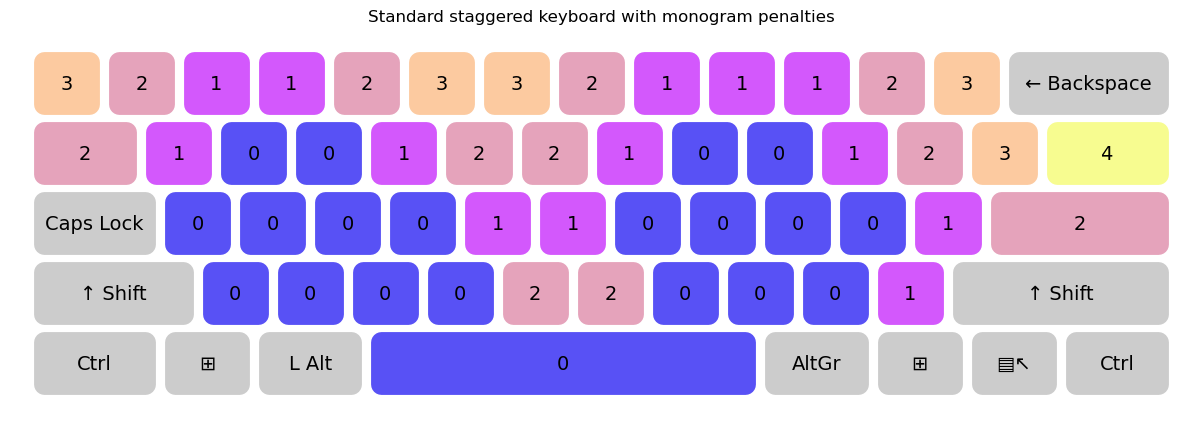

In [12]:
ROW_STAGGER = { 0: 0, 1: .5, 2: .75, 3: 1.25, 4: 1.75 }
                
def std_key_shape(x, y, w, h):
    if x > 6:
        x -= 1


    if x == 0 and y == 1: # '→':
        x -= .5
        w = 1.5
    
    if y == 4: # space bar
        w = 5.25
        x = 2.75
        
    if y == 1 and x == 13: # the / key above the enter
        w = 1.75
    
    if y == 2 and x == 12: # enter
        w = 2.5
        
    if y not in ROW_STAGGER: 
        raise ValueError(f"Row must be 0..=4, got {y} instead.")

    x += ROW_STAGGER[y]

    return x, y, w, h
        
STD_EXTRA_KEYS = [
    (13, 0, 2.25, 1, '← Backspace'),
    
    (0, 2, 1.75, 1, 'Caps Lock'),
    
    (0, 3, 2.25, 1, '↑ Shift'),
    (12.25, 3, 3, 1, '↑ Shift'),

    (0, 4, 1.75, 1, 'Ctrl'),
    (1.75, 4, 1.25, 1, '⊞'),
    (3, 4, 1.5, 1, 'L Alt'),
    (9.75, 4, 1.5, 1, 'AltGr'),
    (11.25, 4, 1.25, 1, '⊞'),
    (12.5, 4, 1.25, 1, '▤↖'),
    (13.75, 4, 1.5, 1, 'Ctrl'),
]
STANDARD_KBD = Keyboard('Standard staggered keyboard', STANDARD_FINGERS, STANDARD_PENALTIES, std_key_shape, STD_EXTRA_KEYS)

STANDARD_KBD.display()

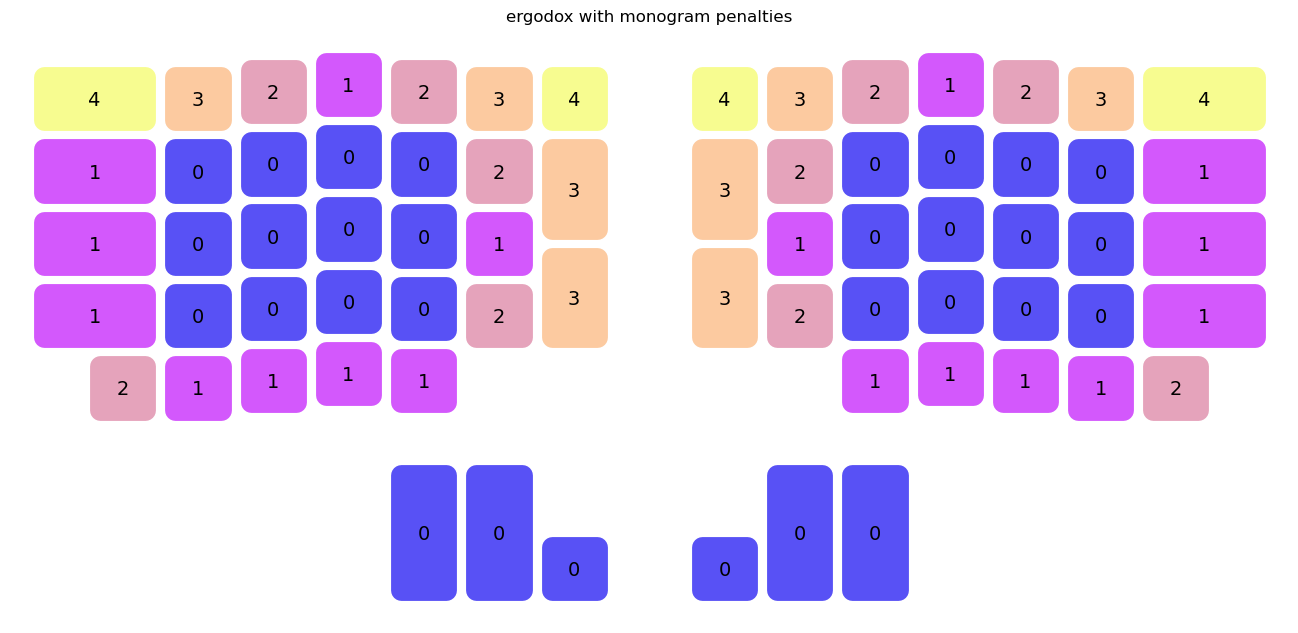

In [13]:
ERGODOX_VSTAG = {2: .1, 3: .2, 4: .1, 10: .1, 11: .2, 12: .1} # x => delta y
def ergodox_key_shape(x, y, w, h):
    if x == 0 and y <= 3:
        w = 1.75
        x -= .75
    
    if x == 14 and y <= 3:
        w = 1.75

    if x in (6, 8) and y in (1, 3):
        h = 1.5
        if y == 3:
            y -= .5

    # thumb blocks
    if y == 5:
        y += .5
        if x in (6, 8):
            y += 1
        else:
            h += 1
    
    # vertical stagger
    if y <= 4:
        y -= ERGODOX_VSTAG.get(x, 0)
    return x, y, w, h
                
        
        
ERGODOX = Keyboard('ergodox',

# note: in the middle columns, there are 2 tall keys, not 3, but I'm not sure how to represent it here,
# so for now, it's set like there are 3.
'''
0012333 6667899
0012333 6667899
001233   667899
0012333 6667899
00123     67899
    444 555
''', # ehm... in reality, I press the outermost keys on the top row with the ring fingers, not pinky, so...
# maybe it's better to write the real usage here...

'''
4321234 4321234
1000023 3200001
100001   100001
1000023 3200001
21111     11112
    000 000
''', ergodox_key_shape)

ERGODOX.display()

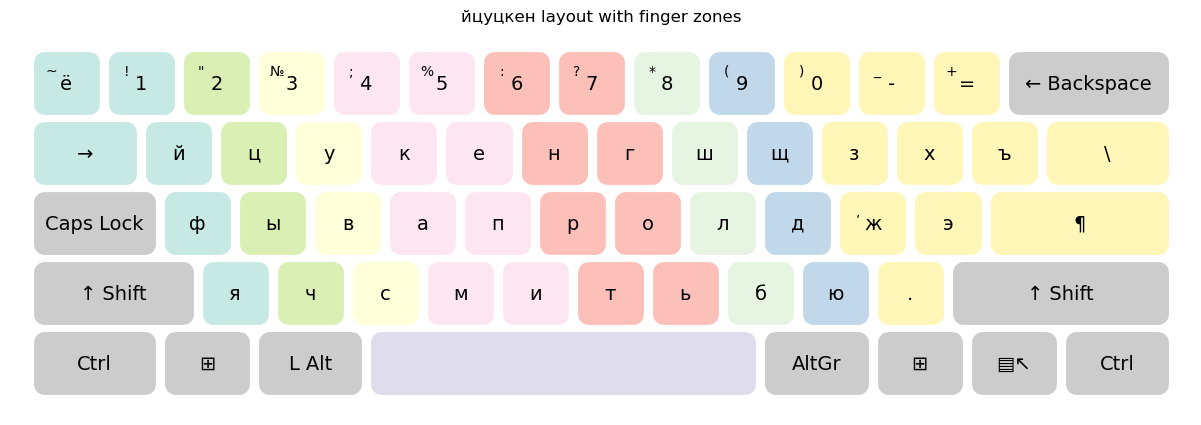

In [14]:
class Layout:
    """Keeps positions of keys on a particular keyboard."""
    def __init__(self, name, layout_config, debug=False):
        """Initialize the layout. `layout_config` must be either text, or 2-tuple (layout text, Keyboard instance)."""

        if isinstance(layout_config, tuple):
            if len(layout_config) != 2:
                raise ValueError(f'Layout must be either a string, or a 2-tuple (layout, keyboard). Got tuple of {len(layout_config)} instead.')
            layout_text, keyboard = layout_config
        else:
            layout_text, keyboard = (layout_config, STANDARD_KBD)

        layers = layout_text.lstrip().rstrip().split('\n\n')
        maps = [parse_layer(l) for l in layers]
        if debug: print('layout', layers)
        keys = ''.join(k for m in maps for k in m.values())
        if debug: print('layout', keys)
        key_counts = defaultdict(int)
        for k in keys:
            key_counts[k] += 1

        for k in set(keys):
            if key_counts[k] > 1 and k not in ('⌴', '¶', '→'):
                print(f'key "{k}" repeated: {key_counts[k]}')

        missing = BASE_KEYS - set(keys)

        if missing:
            raise ValueError(f"Missing keys: {''.join(missing)}, present keys: {''.join(keys)}")

        # making a dict: {letter: (layer, row, column, <finger id>, <finger num in hand>, hand, <pos penalty>)}
        # the last 4 items come from get_finger_props(...) calls
        # make any changes here => change the pd.DataFrame call below
        data = {}
        
        for il, layer in enumerate(maps):
            for (ir, ic), k in layer.items():
                if debug: print(il, ir, ic, k, (ir, ic) in keyboard.keymap)
                if k != '∅' and (ir, ic) in keyboard.keymap:
                    data[k] = {'layer': il, 'row': ir, 'column': ic,
                               'key_count': key_counts[k],
                               **keyboard.keymap[(ir, ic)]}

        self.name = name
        self.keymap = pd.DataFrame.from_dict(data, orient='index')
        self.keyboard = keyboard
        self.original_text = layout_text


    def get_monogram_cost(self, l2):
        """Simply looks up keymap and gets pos_penalty field. Lowercases the letters."""
        
        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # here we should but don't penalize Shift/AltGr pressing
            else:
                if l2 in BASE_KEYS or l2.lower() in BASE_KEYS:
                    print(l2)
                    print(self.keymap.index)
                    raise ValueError(f'base key \'{l2}\' is not in the layout! (may be caused by unquoted backslash)')
                return 0

        return self.keymap.loc[l2].penalty


    # THE MAIN PENALTIES RULES
    # Here we assign costs and also put a text name for the reason why bigram got it,
    # to quickly see WTF is happening
    def get_bigram_cost(self, bigram):
        l1, l2 = bigram

        if l2 not in self.keymap.index:
            if l2.lower() in self.keymap.index:
                l2 = l2.lower() # lowercase (= no penalties for shifts)
            else:
                return 0, 'L2 not in kbd'
        k2 = self.keymap.loc[l2]

        if l1 not in self.keymap.index:
            if l1.lower() in self.keymap.index:
                l1 = l1.lower() # lowercase of l1.
            else:
                return 0, 'L1 not in kbd'
        k1 = self.keymap.loc[l1]

        rules = (
            (k1.ftype == 0 or k2.ftype == 0, 0, 'space bar'),
            (k1.hand != k2.hand, 0, 'altern hands'),
            (l1 == l2, 0, 'same key'),

            (abs(k2.row - k1.row) >= 2 and k1.ftype == k2.ftype, 8, 'same finger over row'),
            (k1.ftype == k2.ftype, 6, 'same finger adj row'),

            (k1.ftype == 1 and k2.ftype == 4, 2, 'index -> pinky'),

            (abs(k1.ftype - k2.ftype) == 1 and abs(k2.row - k1.row) > 1, 10, 'adj finger over row'),
            (abs(k1.ftype - k2.ftype) == 2 and abs(k2.row - k1.row) > 1, 8, 'over 1 finger, over 1 row'),
            (k1.ftype == 4 and k2.ftype == 1 and abs(k2.row - k1.row) > 1, 4, 'pinky -> index over 1 row'),
            (k1.ftype == 1 and k2.ftype == 4 and abs(k2.row - k1.row) > 1, 6, 'over 2 fingers, over 1 row'),
            
            (k1.ftype > k2.ftype + 1 and k2.row == k1.row, 0, 'in, over 1 finger, same row'),
            (k1.ftype > k2.ftype + 1 and abs(k2.row - k1.row) == 1, 1, 'in, over 1 finger, abj row'),
            (k1.ftype == k2.ftype + 1 and k2.row <= k1.row, 1, 'in, adj finger, same or adj row'),
            (k1.ftype > k2.ftype and k2.row > k1.row, 0, 'in, lower row'),
            
            (k1.ftype == 1 and k2.ftype == 2 and k1.row == k2.row, 1, 'index->middle same row'),
            (k2.ftype > k1.ftype, 4, 'out, over one finger'),
            (k1.ftype + 1 == k2.ftype and k1.row == k2.row, 3, 'out, next finger'),
            (k1.ftype + 1 == k2.ftype and abs(k1.row - k2.row) >= 1, 5, 'out, next finger'),
        )

        for cond, penalty, reason in rules:
            if cond:
                return penalty, reason

        return 4, 'none'

    def keycaps(self):
        keycaps = defaultdict(list)
        for k, r in self.keymap.sort_values('layer').iterrows():
            keycaps[(r['row'], r['column'])].append(k)
        return keycaps

    def display(self):
        """
        Shows the layout with the keyboard.
        """
        
        colors = self.keymap.groupby(['row', 'column']).agg({'finger': 'first'})['finger'].apply(lambda f:
                 lighten_color(plt.cm.Set3((f + (f % 2) * 10) / 20), .5)).to_dict()
        self.keyboard.raw_display(self.keycaps(), colors, f"{self.name} layout with finger zones")

l = Layout('йцуцкен', r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''')
l.display()

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [15]:
layouts = {
    # standard Russian layout
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщъ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅!"№;% ;\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # https://habr.com/ru/articles/717912/
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
4321113 311123
3210012 210012
 200001 100001
 100002 2000
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)),
    'optozorax': # https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап   ролджэ
'ячсиы∅ ,шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ $∅∅∅∅∅∅
&∅∅∅∅∅   ∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап   ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :∅?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [16]:
layouts2 = {}
for k, definition in layouts.items():
    layouts2[k] = Layout(k, definition)

key """ repeated: 2
key "?" repeated: 2
key ";" repeated: 2
key "." repeated: 2
key """ repeated: 3
key ":" repeated: 2
key ";" repeated: 2
key "." repeated: 2


In [17]:
class Result:
    # Gets the cost for input KBD text, bigrams & fingers maps
    def __init__(self, corpus, layout):
        bigram_df = corpus.bigrams.copy()

        # taking the text of keyboard layout and encode it into keymap a dataframe
        bigram_df['price_l2'] = bigram_df.l2.apply(layout.get_monogram_cost) * 2 # double monograms costs

        # calculate bigrams cost
        bigram_df[['price_di', 'category']] = bigram_df.bigram.apply(lambda d: pd.Series(layout.get_bigram_cost(d)))
        bigram_df['price'] = bigram_df.price_l2 + bigram_df.price_di
        bigram_df['cost'] = bigram_df.price * bigram_df.num
        bigram_df['finger'] = bigram_df['l2'].map(layout.keymap.finger)
        bigram_df['column'] = bigram_df['l2'].map(layout.keymap.column)
        bigram_df['row'] = bigram_df['l2'].map(layout.keymap.row)
        self.bigrams = bigram_df
        self.corpus = corpus # it's not copied here, just a pointer
        self.layout = layout # also not copied
        self.score = bigram_df.cost.sum() / bigram_df.num.sum()

    def compare(self, other):
        x = self.bigrams[['bigram', 'num', 'category', 'price', 'cost']].merge(
            other.bigrams[['bigram', 'category', 'price', 'cost']],
            on='bigram', suffixes=['_old', '_new'])
        x['delta'] = x['cost_new'] - x['cost_old']
        return x[x.delta != 0].sort_values('delta', ascending=False)

    def display(self, what='costs'):
        show_costs = what in ('cost', 'costs')
        show_nums = what in ('freq', 'frequencies', 'num', 'nums')
        
        if show_costs:
            df = self.bigrams.groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum'})
            df['meancost'] = df['cost'] / df['num']
            
            min_cost = df['meancost'].min()
            max_cost = df['meancost'].max()
            
            colors = df['meancost'].apply(color_scale, args=(min_cost, max_cost)).to_dict()
            self.layout.keyboard.raw_display(
                df['meancost'].round(2).to_dict(), colors, f'{self.layout.name} costs (on 2nd keys of bigrams)')
            
        elif show_nums:
            nums = self.bigrams.groupby(['row', 'column']).agg({'num': 'sum'}).round(0)['num']
            min_num = nums.min()
            max_num = nums.max()
            colors = nums.apply(color_scale, args=(min_num, max_num))
            self.layout.keyboard.raw_display(
                nums.to_dict(), colors.to_dict(), f'{self.layout.name} frequencies (on 2nd keys of bigrams)')
            
        else:
            raise ValueError('what must be \`cost\` or \`freq\`.')
    
    def combodata(self):
        filtered = self.bigrams[(self.bigrams.l2 != '⌴') & (self.bigrams.l1 != '⌴')]
        l1 = filtered.rename(columns={'l1': 'l'})[['l', 'cost', 'num']]
        l2 = filtered.rename(columns={'l2': 'l'})[['l', 'cost', 'num']]
        ll = pd.concat([l1, l2]).groupby('l').agg({'cost': 'sum', 'num': 'sum'})
        ll = ll.merge(self.layout.keymap[['layer', 'row', 'column']], left_index=True, right_index=True
                 ).reset_index(names='letter').groupby(['layer', 'row', 'column']
                 ).agg({'cost': 'sum', 'num': 'sum', 'letter': 'first'})

        ll['price'] = ll.cost / ll.num
        return ll
        
    def combomap(self, other):     
        layouts = [(i, i.layout.keyboard.key_coords(), i.combodata()) for i in (self, other)]
        width = max(i[1][1] for i in layouts)
        all_heights = sum(i[1][2] for i in layouts) + 1
        fig, axes = plt.subplots(2, 1, figsize=(width, all_heights))

        ll = pd.concat([i[2] for i in layouts])
        max_cost = ll['cost'].max() ** .5
        max_num = ll['num'].max() ** .5
        max_price = ll['price'].max()
        min_price = ll['price'].min()

        plt.text(width / 2, all_heights / 2 + .5, 'Layouts comparison. Size = key\'s bigrams cost. Color = mean price. Scales are the same.',
             size=14, ha='center')

        for (result, (all_coords, width, height), ll), ax in zip(layouts, axes):
            ll2 = ll.reset_index().groupby(['row', 'column']).agg({'cost': 'sum', 'num': 'sum', 'letter': 'sum'})
            ll2['price'] = ll2['cost'] / ll2['num']
            ax.set_xlim(0, width)
            ax.set_ylim(0, height)
            ax.set_axis_off()
            ax.set_title(f'{result.layout.name}')
            keycaps = result.layout.keycaps()

            for ir, ic, x, y, w, h, _ in all_coords:
                if (ir, ic) not in ll2.index: continue
                
                vals = ll2.loc[(ir, ic)]
                cost = vals['cost'] ** .5
                num = vals['num'] ** .5
                price = vals['price']
                color = color_scale(price, min_price, max_price, plt.cm.viridis, lighten=.6)

                ax.add_patch(plt.Circle((x, height - y - .5), cost / max_cost / 1.5, color=color))

                if (ir, ic) not in keycaps: continue
                cap = keycaps[(ir, ic)]
                ax.text(x, height - y - .55, cap[0].replace('⌴', ''),
                     fontdict={'color':  '#000', 'size': 12, 'ha': 'center'})
                
    def combochart(self, other):
        self_ll = self.combodata()
        other_ll = other.combodata()
        ll2 = self_ll.merge(other_ll, on='letter', how='outer', suffixes=['1', '2'])
        ax = ll2.plot.scatter(x='num1', y='cost1', figsize=(10, 6), s=50)
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num1'] + 1000, r['cost1']))
        ll2.plot.scatter(x='num2', y='cost2', ax=ax, color='#c44')
        for i, r in ll2.iterrows():
            ax.annotate(r['letter'].replace('¶', '\\n'), (r['num2'] + 1000, r['cost2']))
        ax.set_title(f'Comparison of {self.layout.name} (blue) and {other.layout.name} (red)')


def compare(results_dict, key1, key2):
    return results_dict[key1].compare(results_dict[key2])

In [18]:
results = {}

for k, lyt in layouts2.items():
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.6343
layout usphonetic: 2.4724
layout rusdvorak: 1.3702
layout диктор: 1.1283
layout зубачёв: 0.9839
layout скоропис: 1.1487
layout ант: 1.3549
layout ugnvs: 1.7091
layout леонов: 0.9475
layout optozorax: 1.3738
layout ergodox: 2.3876
layout тест1: 2.3911
layout тест2: 2.0421
layout тест3: 1.6528
layout тест4: 1.4791
layout тест5: 1.319
layout тест6: 1.409
layout тест7: 1.4196
layout тест8: 1.4503
layout тест9: 1.4691
layout тест10: 1.188
layout тест11: 1.2486
layout тест12: 1.2491
layout тест13: 1.2516
layout тест14: 1.1922
layout тест15: 1.051
layout тест16: 1.0456
layout тест17: 0.9832
layout тест18: 1.0177
layout тест19: 1.0103
layout тест20: 1.0184
layout тест21: 0.9507
layout тест22: 0.9507
layout тест23: 0.9116
layout тест24: 0.8542
layout тест25: 0.9191
layout ино1: 0.8391
layout тест26: 0.8647
layout тест27: 0.8704
layout ино2: 0.6178
layout тест28: 0.8282


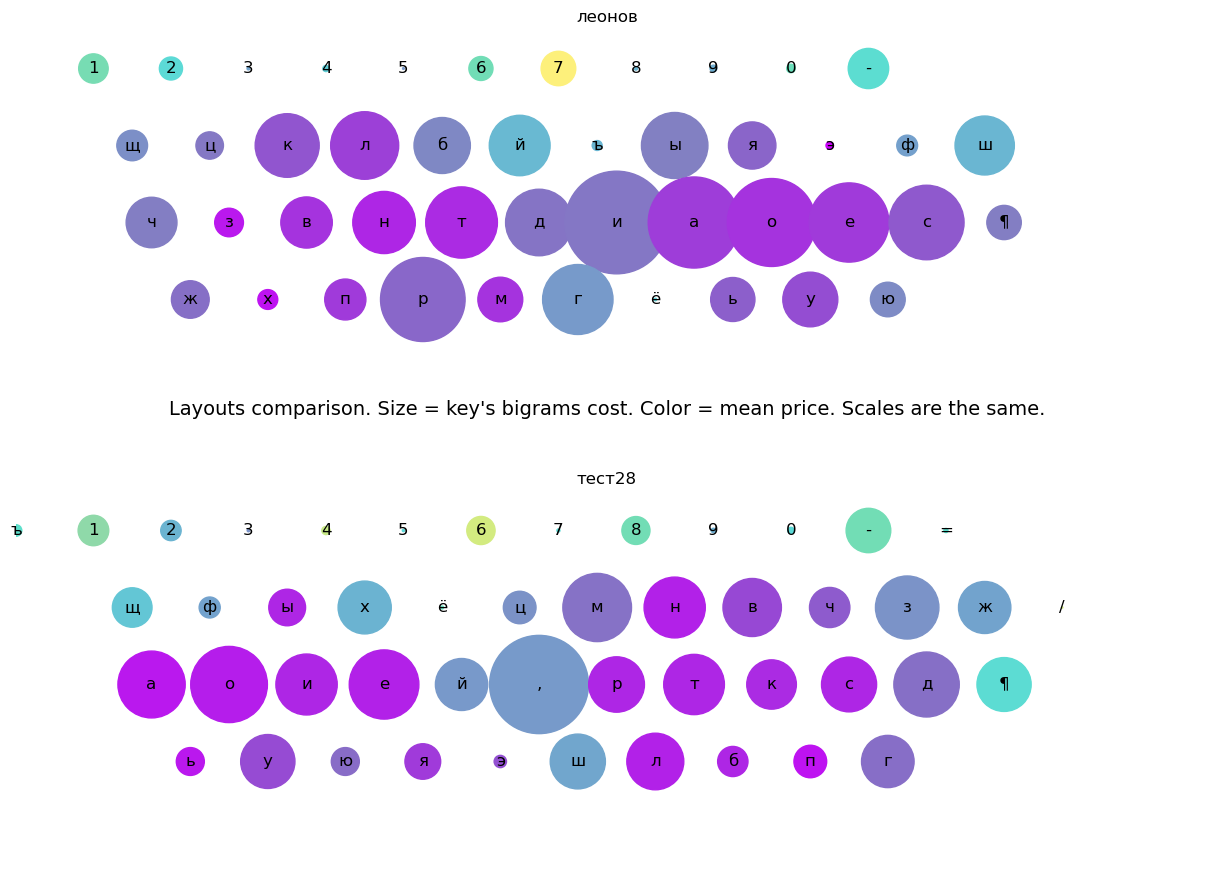

In [19]:
results['леонов'].combomap(results['тест28'])

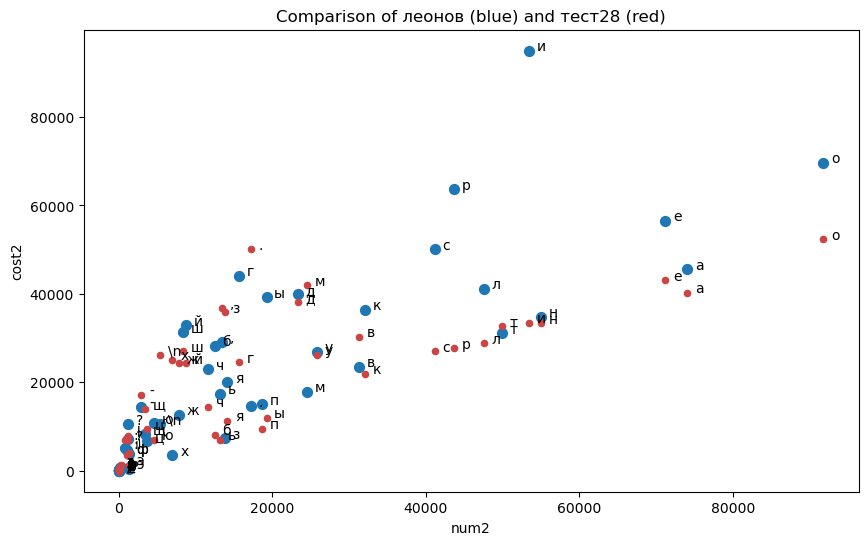

In [20]:
results['леонов'].combochart(results['тест28'])

# Final Standings <a name="standings">

In [21]:
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('тест17', ''),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест28', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
df = pd.DataFrame(
    [(k, results[k].score.round(3), d) for k, d in chosen_kbd]
, columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
print(df.to_markdown(index=False))

# how well I am against Leonov's layout (the best of eariler authors' layouts)
1 - results['тест27'].score / results['леонов'].score

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.618 | Alien #2, many counterparts on AltGr   |
| тест28     |   0.828 | Best and currently in use on my laptop |
| ино1       |   0.839 | Alien #1, rare letters on AltGr        |
| леонов     |   0.947 | Leonov                                 |
| тест17     |   0.983 |                                        |
| зубачёв    |   0.984 | Zubachov                               |
| диктор     |   1.128 | Dictor                                 |
| скоропис   |   1.149 | Skoropis                               |
| тест10     |   1.188 | First optimized after hand testing     |
| ант        |   1.355 | ANT                                    |
| rusdvorak  |   1.37  | Dvorak translit                        |
| optozorax  |   1.374 | ErgoDox Moonlander, alien              |
| тест9      |   1.469 | First hand-tested                      |
| ugnvs   

0.08137311874142017

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
0000123 6789999
001233  66789999
 01233  66789999
 01233  667899
4
''', '''
4321111 1111234
210012  21001123
 00001  10000123
 00002  200001
0
'''))
```

In [22]:
'''
→эыфх:  цнмвчзжш
 аоией  ,ртксд¶
 ьуюяё  щлбпг
'''
lyt = Layout('тест29', r'''

ъ12345 67890-=
→щфыхё цнмвчзж
 аоией шртксд¶
 ьуюяэ ,лбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅
∅
''')


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 4), '')

тест29 : 0.9479 


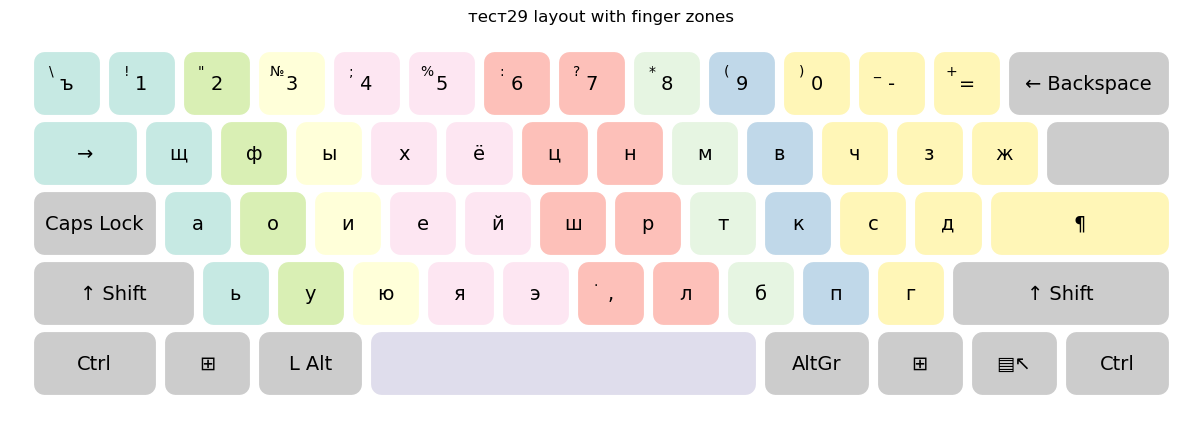

In [23]:
lyt.display()

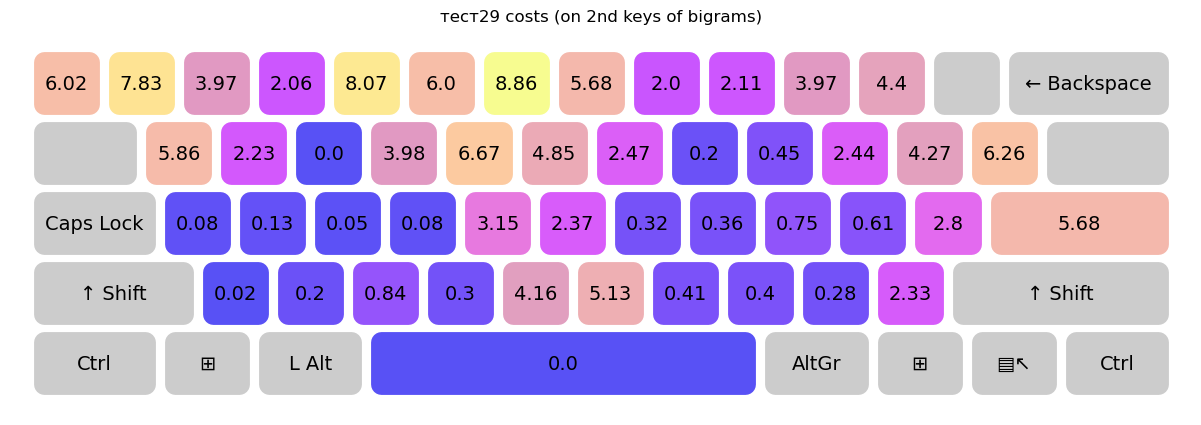

In [24]:
r.display('cost')

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

## Losses

In [25]:
compare(results, 'тест28', 'тест29') #.head(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
109,⌴н,8502,space bar,0,0,space bar,2,17004,17004
23,ен,3875,altern hands,0,0,altern hands,2,7750,7750
207,..,3334,same key,2,6668,same key,4,13336,6668
247,он,3123,altern hands,0,0,altern hands,2,6246,6246
140,ин,2492,altern hands,0,0,altern hands,2,4984,4984
...,...,...,...,...,...,...,...,...,...
179,им,1572,altern hands,2,3144,altern hands,0,0,-3144
204,ам,2069,altern hands,2,4138,altern hands,0,0,-4138
106,ем,2112,altern hands,2,4224,altern hands,0,0,-4224
189,ом,3111,altern hands,2,6222,altern hands,0,0,-6222


## Gains

In [26]:
compare(results, 'тест28', 'тест29').tail(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
374,нд,350,"out, over one finger",6,2100,index -> pinky,4,1400,-700
111,см,391,"in, over 1 finger, abj row",3,1173,"in, over 1 finger, abj row",1,391,-782
112,еш,420,altern hands,4,1680,altern hands,2,840,-840
269,уш,431,altern hands,4,1724,altern hands,2,862,-862
395,нт,471,same finger adj row,6,2826,"out, over one finger",4,1884,-942
222,аш,471,altern hands,4,1884,altern hands,2,942,-942
445,ыш,480,altern hands,4,1920,altern hands,2,960,-960
553,рм,245,same finger adj row,8,1960,"out, over one finger",4,980,-980
43,ош,515,altern hands,4,2060,altern hands,2,1030,-1030
420,ум,589,altern hands,2,1178,altern hands,0,0,-1178


You can save comparison table to CSV:

In [27]:
compare(results, 'леонов', 'тест29').to_csv('leonov-test29.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [28]:
results['тест29'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

,bigram,num,l1,l2,t1,t2,freq,price_l2,price_di,category,price,cost,finger,column,row
109,⌴н,8502,⌴,н,-,c,0.013569,2,0,space bar,2,17004,6.0,8.0,1.0
132,⌴-,3685,⌴,-,-,-,0.005881,4,0,space bar,4,14740,9.0,12.0,0.0
74,.¶,2327,.,¶,-,-,0.003714,4,2,index -> pinky,6,13962,9.0,13.0,2.0
207,..,3334,.,.,-,-,0.005321,4,0,same key,4,13336,6.0,7.0,3.0
78,⌴з,2924,⌴,з,-,c,0.004667,4,0,space bar,4,11696,9.0,12.0,1.0
253,"м,",752,м,",",c,-,0.001200,4,10,adj finger over row,14,10528,6.0,7.0,3.0
327,ей,1000,е,й,v,c,0.001596,2,6,same finger adj row,8,8000,3.0,5.0,2.0
23,ен,3875,е,н,v,c,0.006184,2,0,altern hands,2,7750,6.0,8.0,1.0
202,аз,1924,а,з,v,c,0.003071,4,0,altern hands,4,7696,9.0,12.0,1.0
170,⌴д,3427,⌴,д,-,c,0.005469,2,0,space bar,2,6854,9.0,12.0,2.0


## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [29]:
key = 'тест29' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS) & BG.l2.isin(BASE_KEYS)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [30]:
lyt.keymap
# or 
# results['тест28'][1]

,layer,row,column,key_count,finger,ftype,hand,penalty
ъ,0,0,0,1,0,4,0,3
1,0,0,1,1,0,4,0,2
2,0,0,2,1,1,3,0,1
3,0,0,3,1,2,2,0,1
4,0,0,4,1,3,1,0,2
5,0,0,5,1,3,1,0,3
6,0,0,7,1,6,1,1,3
7,0,0,8,1,6,1,1,2
8,0,0,9,1,7,2,1,1
9,0,0,10,1,8,3,1,1


# Where do letters want to move? <a name="letters-move">
    
TODO

## Visualizing Frequencies in QGIS <a name="qgis">

In [31]:
letters = results['тест29'].bigrams[['column', 'row', 'l2', 'num']].groupby(['column', 'row', 'l2']).agg({'num': 'sum'}).reset_index()
letters['WKT'] = 'POINT(' + letters['column'].astype(str) + ' ' + (4 - letters['row']).astype(str) + ')'
letters.to_csv('letters-freq.csv')

# Is Ergodox better? <a name="is-ergodox-better">

Let's compare the standard layout on standard keyboard with it on Ergodox. This of course is not a good representation, but may shed light on problems with some keys having to move to awkward places.

The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

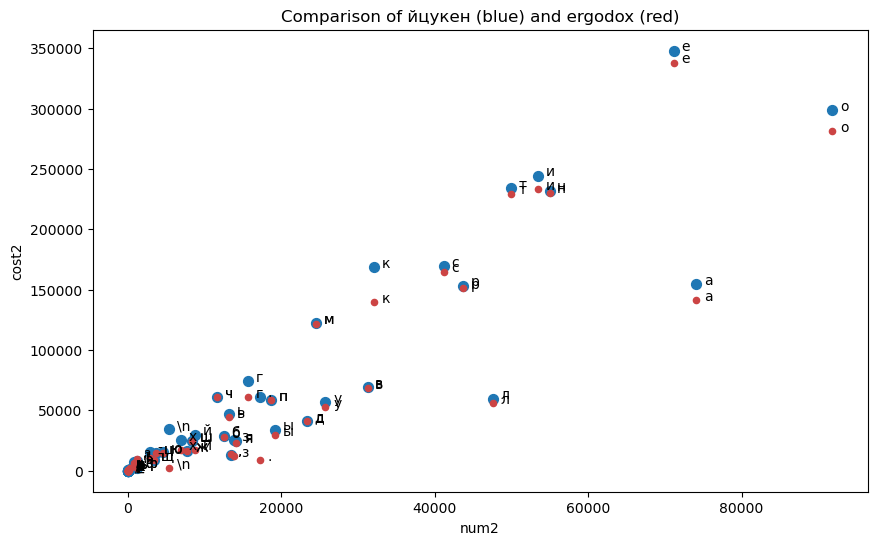

In [32]:
results['йцукен'].combochart(results['ergodox'])

In [33]:
compare(results, 'йцукен', 'ergodox').head(20)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
520,"х,",356,same finger adj row,6,2136,same finger over row,8,2848,712
786,-с,85,altern hands,0,0,"over 1 finger, over 1 row",8,680,680
153,а:,61,altern hands,6,366,same finger over row,16,976,610
612,й-,132,altern hands,4,528,same finger adj row,8,1056,528
161,"⌴""",240,space bar,2,480,space bar,4,960,480
637,и:,43,altern hands,6,258,same finger over row,16,688,430
767,о?,98,same finger over row,12,1176,same finger over row,16,1568,392
435,е?,97,altern hands,4,388,altern hands,8,776,388
835,е:,45,altern hands,6,270,same finger adj row,14,630,360
426,а?,86,altern hands,4,344,altern hands,8,688,344


# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

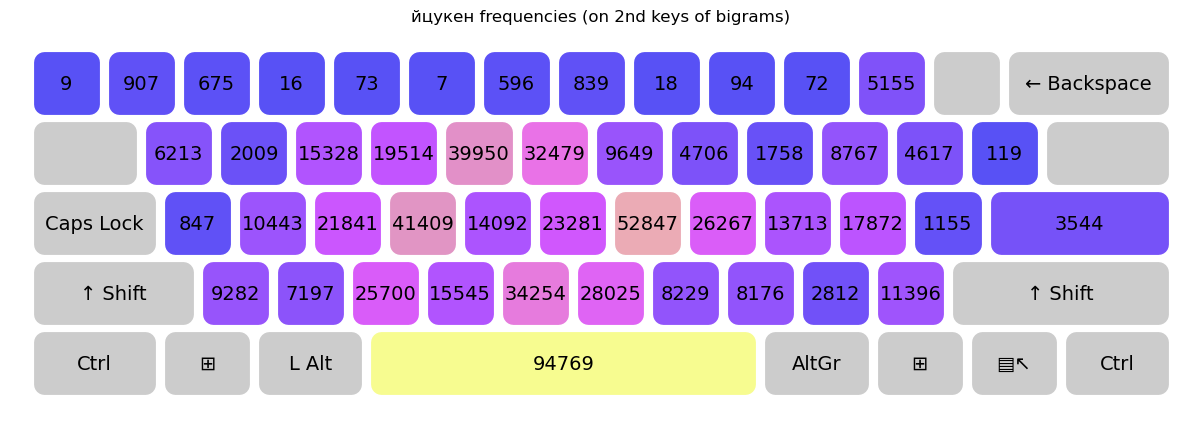

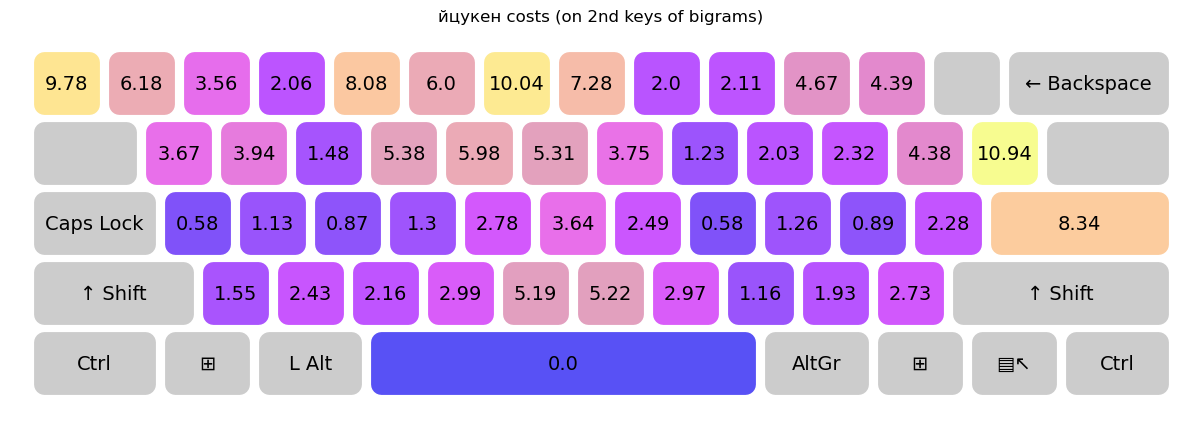

In [34]:
results['йцукен'].display('num')
results['йцукен'].display('cost')

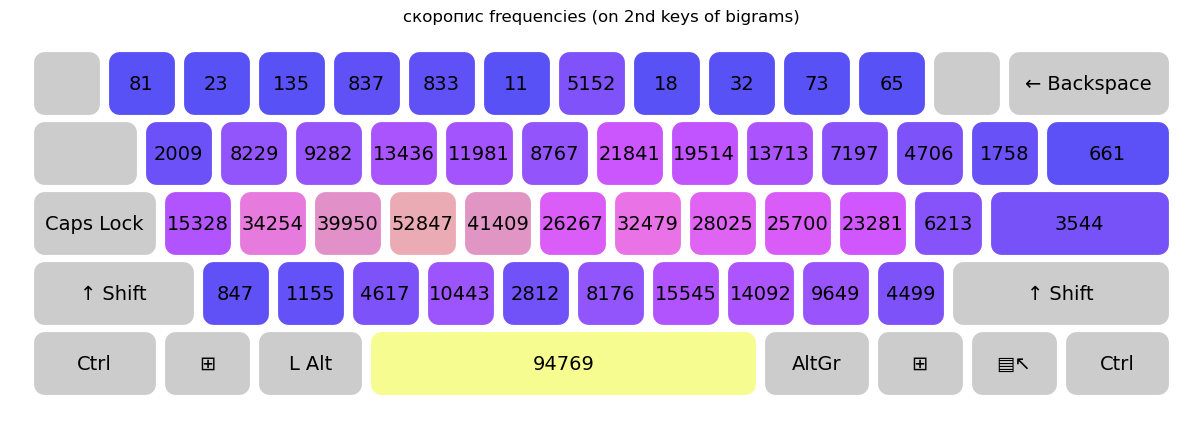

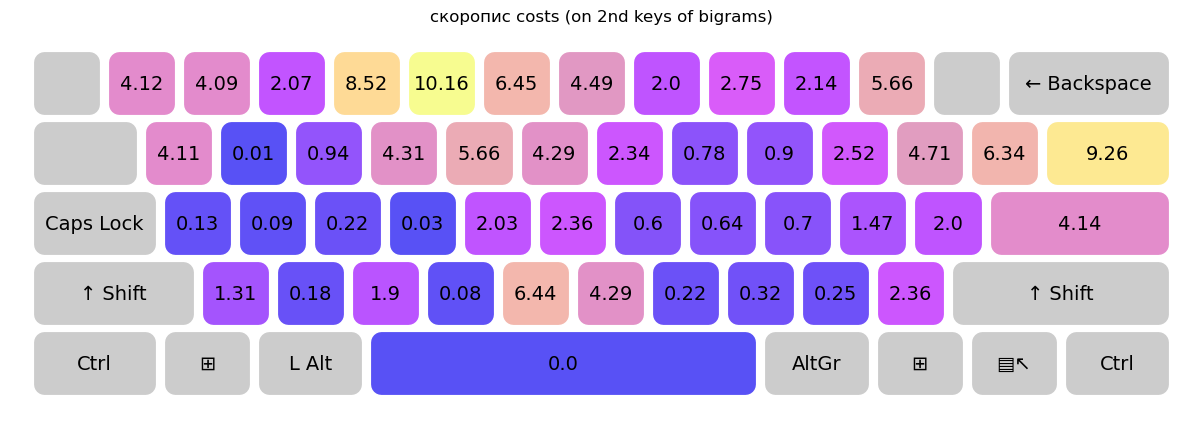

In [35]:
results['скоропис'].display('num')
results['скоропис'].display('cost')

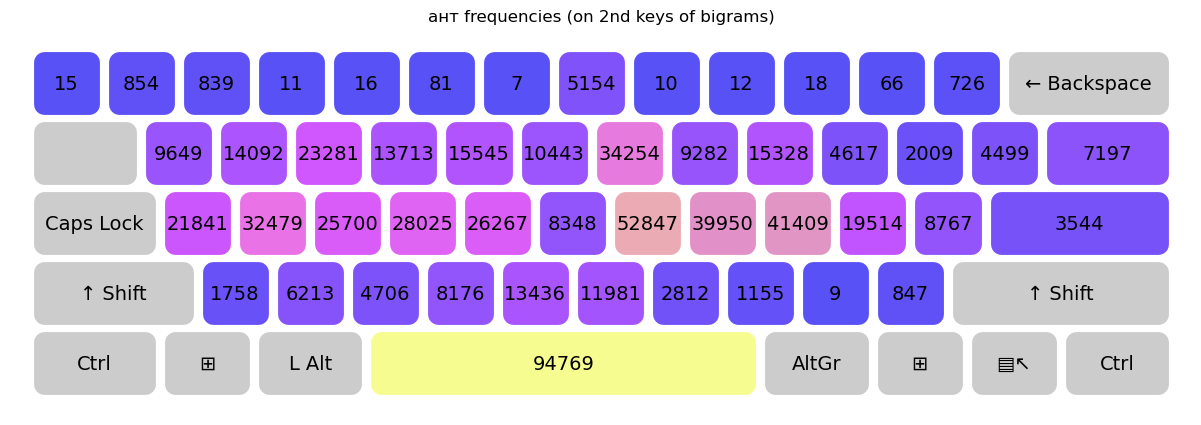

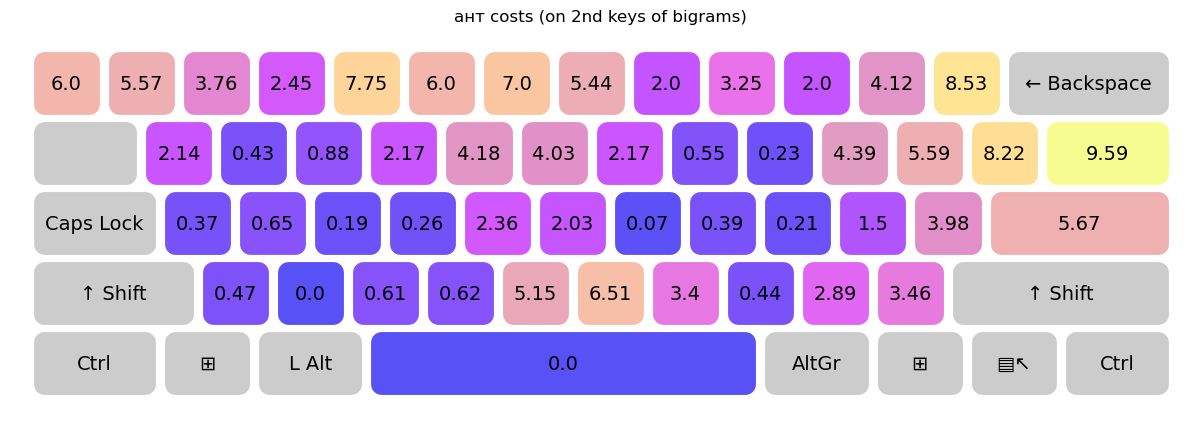

In [36]:
results['ант'].display('num')
results['ант'].display('cost')

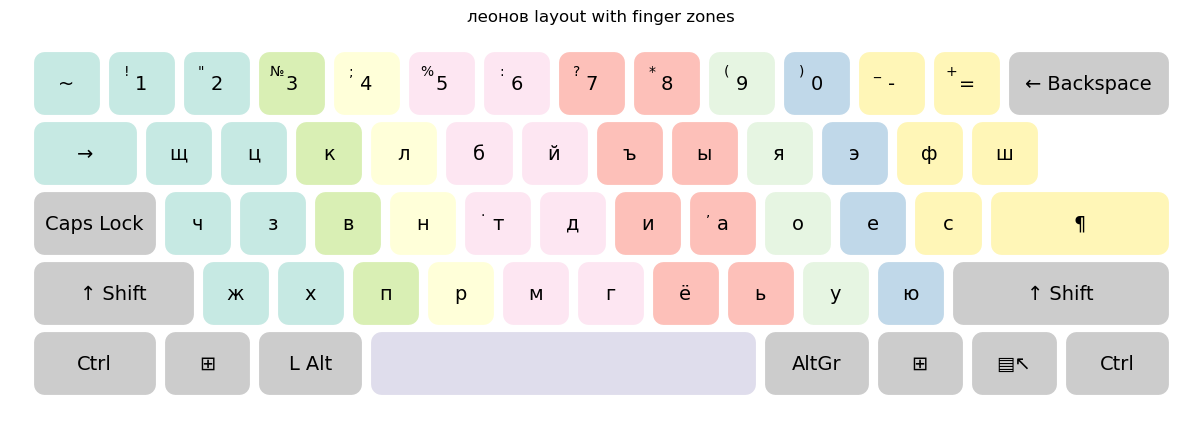

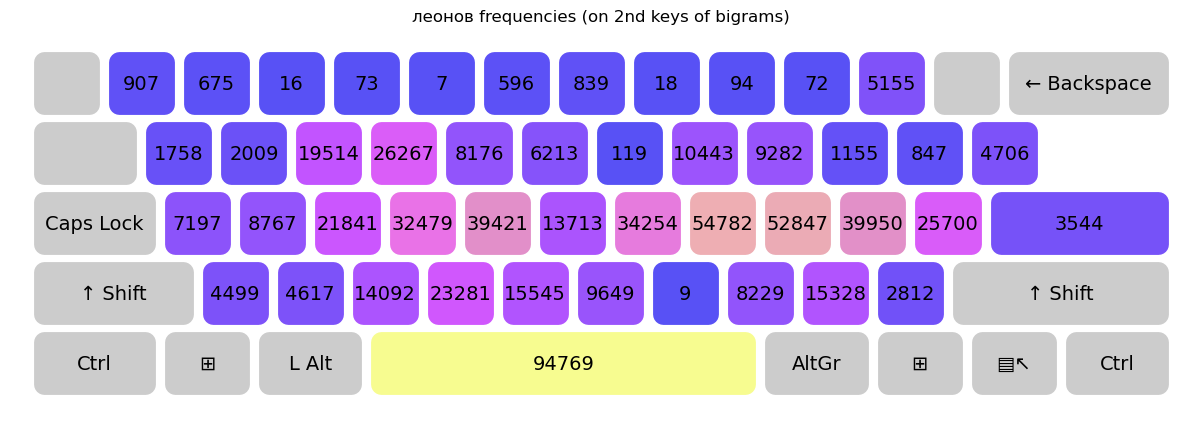

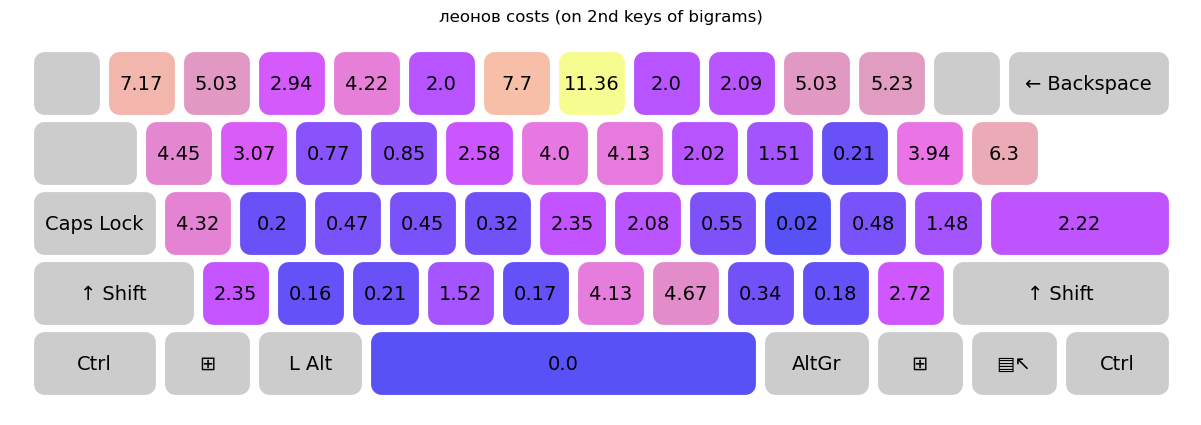

In [37]:
results['леонов'].layout.display()
results['леонов'].display('num')
results['леонов'].display('cost')

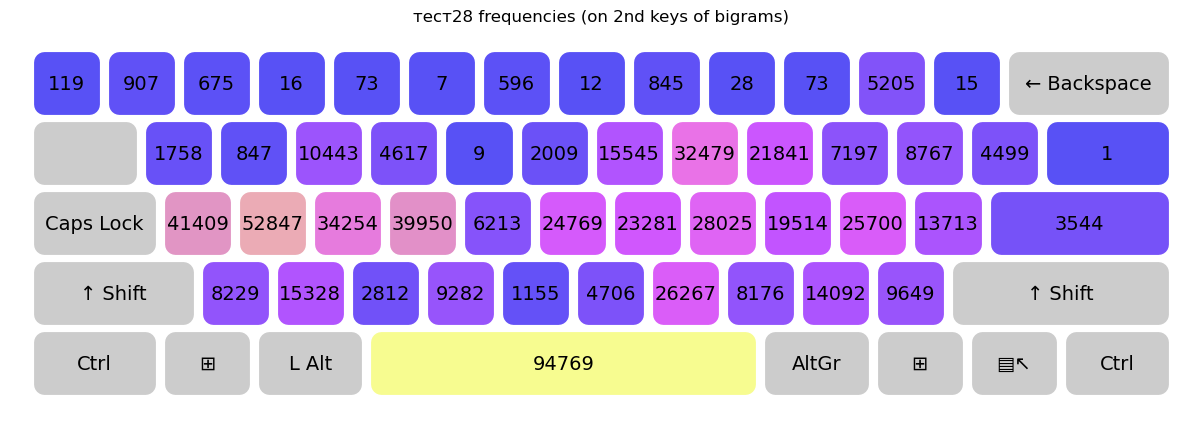

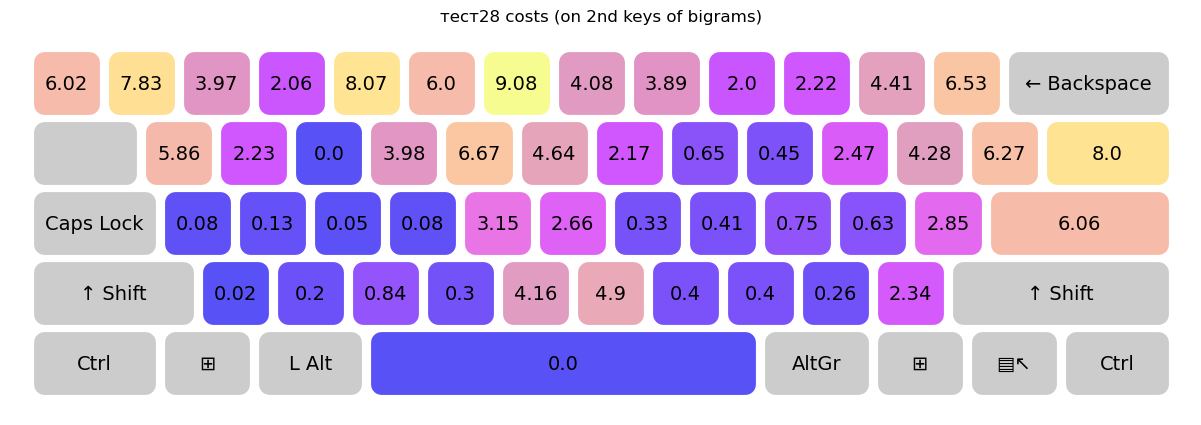

In [38]:
results['тест28'].display('num')
results['тест28'].display('cost')

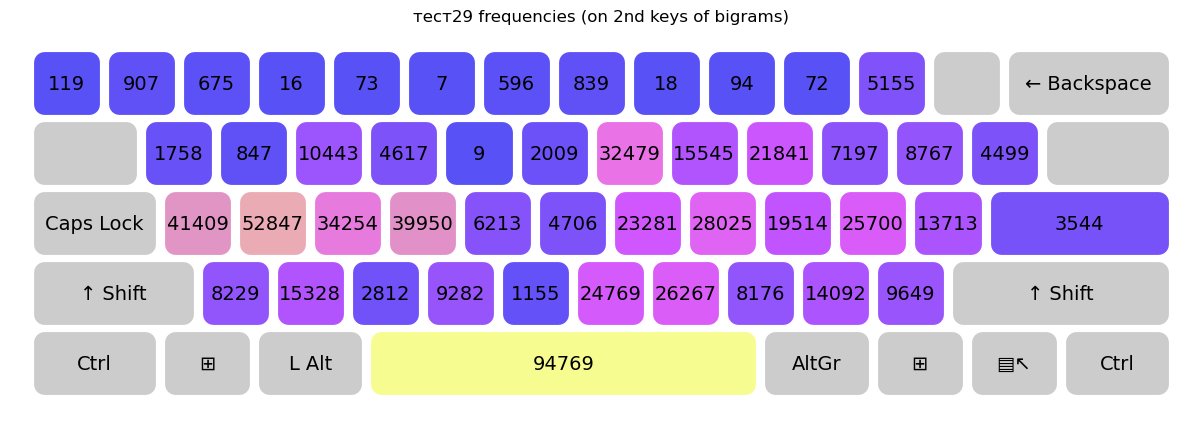

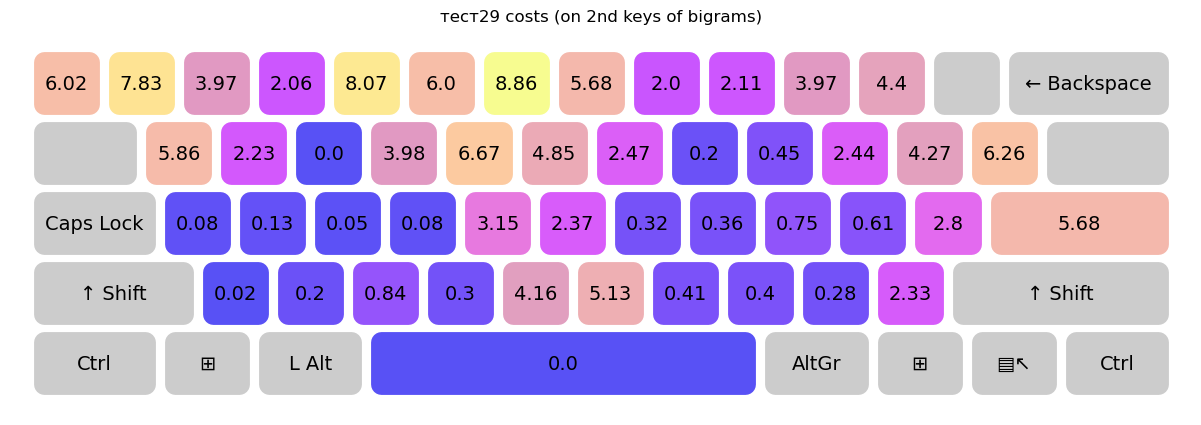

In [39]:
results['тест29'].display('num')
results['тест29'].display('cost')

# Comparison of best others' and mine

In [40]:
r = compare(results, 'леонов', 'тест28')
r.head(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
78,⌴з,2924,space bar,0,0,space bar,4,11696,11696
74,.¶,2327,altern hands,2,4654,index -> pinky,6,13962,9308
202,аз,1924,altern hands,0,0,altern hands,4,7696,7696
207,..,3334,same key,0,0,same key,2,6668,6668
46,⌴м,3299,space bar,0,0,space bar,2,6598,6598
189,ом,3111,altern hands,0,0,altern hands,2,6222,6222
253,"м,",752,altern hands,0,0,same finger adj row,8,6016,6016
124,вс,1446,altern hands,0,0,"out, over one finger",4,5784,5784
529,-т,640,altern hands,0,0,"over 1 finger, over 1 row",8,5120,5120
416,из,1187,altern hands,0,0,altern hands,4,4748,4748


In [41]:
r.tail(30)

,bigram,num,category_old,price_old,cost_old,category_new,price_new,cost_new,delta
269,уш,431,"over 1 finger, over 1 row",12,5172,altern hands,4,1724,-3448
286,ти,1799,altern hands,2,3598,altern hands,0,0,-3598
17,ви,1808,altern hands,2,3616,altern hands,0,0,-3616
126,ис,1820,index -> pinky,2,3640,altern hands,0,0,-3640
362,"ь,",950,same finger adj row,6,5700,altern hands,2,1900,-3800
108,ое,974,"out, over one finger",4,3896,"in, over 1 finger, same row",0,0,-3896
185,ые,1005,"out, over one finger",4,4020,"in, lower row",0,0,-4020
169,ая,1399,"out, over one finger",4,5596,"in, over 1 finger, abj row",1,1399,-4197
72,ми,2268,altern hands,2,4536,altern hands,0,0,-4536
49,ки,2306,altern hands,2,4612,altern hands,0,0,-4612
